In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
#from propublica's public repo for the COMPAS analysis (https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)
cp_url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
cp_df = pd.read_csv(cp_url)

In [2]:
cp_df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [3]:
#high-risk is a score above or equal to 5
cp_df.loc[:,'predicted_reoffense'] = cp_df.loc[:,'decile_score'] >= 5

In [4]:
#filter to African-American and Caucasian as that is the alleged disparity by propublica
cp_df = cp_df[cp_df['race'].isin(['African-American', 'Caucasian'])]

In [5]:
#filter to just relevant metrics
cp_df.loc[:,'actual_reoffense'] = cp_df.loc[:,'two_year_recid'].apply(bool)
cp_df = cp_df.loc[:,['race', 'predicted_reoffense', 'actual_reoffense', 'decile_score']]
cp_df.head()

/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/nick/miniconda3/envs/BPC/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,race,predicted_reoffense,actual_reoffense,decile_score
1,African-American,False,True,3
2,African-American,False,True,4
3,African-American,True,False,8
6,Caucasian,True,True,6
8,Caucasian,False,False,1


In [6]:
cp_df.groupby(['race', 'actual_reoffense']).count()

predicted_reoffense  decile_score
race             actual_reoffense                                   
African-American False                            1795          1795
                 True                             1901          1901
Caucasian        False                            1488          1488
                 True                              966           966

In [7]:
#first calculate accuracy (all correct predictions)
(cp_df['predicted_reoffense'] == cp_df['actual_reoffense']).mean()

0.6508943089430894

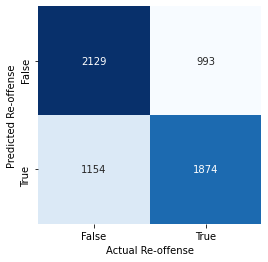

In [8]:
cross_dat  = pd.crosstab(cp_df['predicted_reoffense'], cp_df['actual_reoffense'],
            rownames= ['Predicted Re-offense'],
            colnames= ['Actual Re-offense'])
p_cross = plt.figure(figsize = (4,4))
p_cross = sns.heatmap(cross_dat, annot = True, fmt='d', cbar = False, cmap = 'Blues')
plt.savefig('CountsMatrix_Subset.png')

In [9]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(cp_df['actual_reoffense'], probas_pred=cp_df['decile_score'])

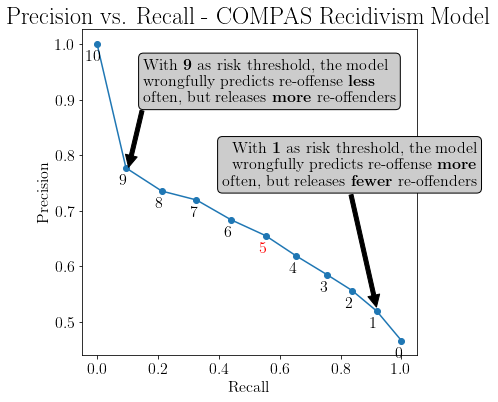

In [53]:
fig, ax = plt.subplots(figsize = (6,6))
plt.scatter(recall, precision)
plt.plot(recall, precision)
ax.set(xlabel='Recall',
       ylabel='Precision',
       title ='Precision vs. Recall - COMPAS Recidivism Model')
plt.rc('text',usetex=True)
font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.rc('axes', titlesize = 20)

ax.annotate(
'''With $\mathbf{9}$ as risk threshold, the model
wrongfully predicts re-offense $\mathbf{less}$
often, but releases $\mathbf{more}$ re-offenders''',
            xy=(recall[9] + .008, precision[9]), xycoords='data',
            xytext=(15, 110), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='left', verticalalignment='top')


ax.annotate(
'''With $\mathbf{1}$ as risk threshold, the model
wrongfully predicts re-offense $\mathbf{more}$
often, but releases $\mathbf{fewer}$ re-offenders''',
            xy=(recall[1], precision[1] + .005), xycoords='data',
            xytext=(100, 120), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.01),
            bbox=dict(boxstyle="round", fc="0.8"),
            horizontalalignment='right', verticalalignment='bottom')

for score_idx, xy in enumerate(zip(recall-.01,precision-.01)):
    if score_idx == 5:
        col = 'red'
    else:
        col = 'black'
    ax.annotate(score_idx, xy=xy, textcoords='data', ha ='center', va = 'top', color = col)

plt.savefig('PrecisionVsRecall.png', bbox_inches="tight")

In [11]:
#what was precision and recall for the threshold they chose: 5?
thresholds[4], recall[4], precision[4]

(5, 0.65364492500872, 0.6188903566710701)

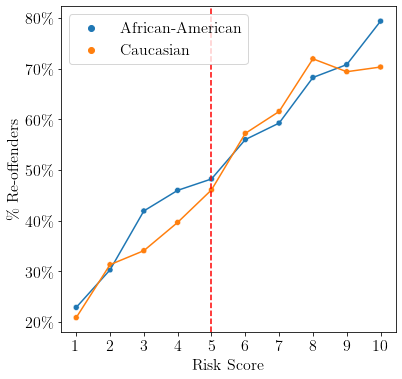

In [12]:
from  matplotlib.ticker import PercentFormatter

recid_by_score = cp_df.groupby(['race', 'decile_score'])['actual_reoffense']\
    .mean().to_frame().reset_index()
recid_by_score
plt.rc('text',usetex=True)

fig, ax = plt.subplots(figsize = (6,6))
sns.lineplot(x='decile_score', y = 'actual_reoffense', data = recid_by_score, hue = 'race', legend=False)
sns.scatterplot(x='decile_score', y = 'actual_reoffense', data = recid_by_score, hue = 'race')

ax.legend(title=False)
ax.set_xticks(range(1,11))
ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
plt.axvline(5, color='red', linestyle = '--')
ax.set(xlabel = 'Risk Score', ylabel = '\% Re-offenders')

plt.savefig('Def1.png', bbox_inches="tight")

In [27]:
agg_by_race = cp_df.groupby(['race','predicted_reoffense'])['actual_reoffense'].value_counts().rename('count').reset_index()
agg_by_race

,race,predicted_reoffense,actual_reoffense,count
0,African-American,False,False,990
1,African-American,False,True,532
2,African-American,True,True,1369
3,African-American,True,False,805
4,Caucasian,False,False,1139
5,Caucasian,False,True,461
6,Caucasian,True,True,505
7,Caucasian,True,False,349


<ipython-input-62-b809d6b74f6a>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Rating 1-5', 'Rating 5-10'])


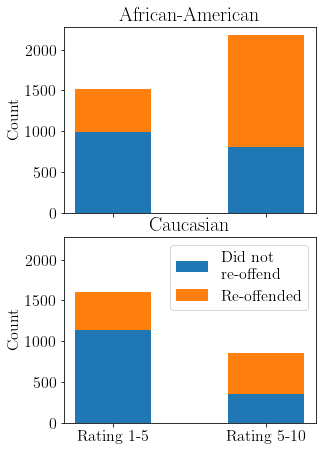

In [62]:
plt.rc('text',usetex=True)
from faceted import faceted
fig, axes = faceted(2, 1, width=4, height=6)
race_cat = ['African-American', 'Caucasian']
for idx, ax in enumerate(axes):
    sub_df = agg_by_race[agg_by_race['race'] == race_cat[idx]]
    ax.bar(sub_df[~sub_df['actual_reoffense']]['predicted_reoffense'],
           sub_df[~sub_df['actual_reoffense']]['count'],
           .5,
           label='''Did not
re-offend''')
    ax.bar(sub_df[sub_df['actual_reoffense']]['predicted_reoffense'],
           sub_df[sub_df['actual_reoffense']]['count'],
           .5,
           label='Re-offended',
           bottom = sub_df[~sub_df['actual_reoffense']]['count'])
    ax.set_xticklabels(['Rating 1-5', 'Rating 5-10'])
    ax.set_xticks([0,1])
    ax.set_ylabel('Count')
    ax.set_title(race_cat[idx])
ax.legend()
# plt.show()

plt.savefig('CountsBars.png', bbox_inches="tight")